# Importar Librerías

In [2]:
import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import cv2
import copy
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim

!pip install einops;

from einops import rearrange
from einops.layers.torch import Rearrange

!pip install -U albumentations;
import albumentations as A
from albumentations.pytorch import ToTensorV2

import glob, numpy as np , random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.9/227.9 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.1/605.1 kB 24.6 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
      Successfully uninstalled albucore-0.0.19
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


# 1. Entendimiento de los datos

## Carga del dataset

In [20]:
import os
import pandas as pd

# Ruta base donde están los datos extraídos
base_path = './dataset'

# Función para crear un DataFrame a partir de las rutas de imágenes y etiquetas
def create_dataframe(mapping_file):
    with open(mapping_file, 'r') as f:
        lines = f.readlines()

    data = []
    for line in lines:
        # Cada línea contiene: image_path, label, additional_info
        path, label, _ = line.strip().split(',')  # Extraer los dos primeros valores
        full_path = os.path.join(base_path, path.strip())  # Construir la ruta completa
        data.append({'image_path': full_path, 'label': int(label.strip())})

    return pd.DataFrame(data)

# Rutas a los archivos de mapeo
train_mapping_file = os.path.join(base_path, 'train.txt')
val_mapping_file = os.path.join(base_path, 'val.txt')
test_mapping_file = os.path.join(base_path, 'test.txt')

# Crear DataFrames
train_df = create_dataframe(train_mapping_file)
val_df = create_dataframe(val_mapping_file)
test_df = create_dataframe(test_mapping_file)

# Mostrar un resumen de los DataFrames
print("Train DataFrame:")
print(train_df.head())

print("\nValidation DataFrame:")
print(val_df.head())

print("\nTest DataFrame:")
print(test_df.head())


Train DataFrame:
                                          image_path  label
0  ./dataset\train/Fruit/Apple/Golden-Delicious/G...      0
1  ./dataset\train/Fruit/Apple/Golden-Delicious/G...      0
2  ./dataset\train/Fruit/Apple/Golden-Delicious/G...      0
3  ./dataset\train/Fruit/Apple/Golden-Delicious/G...      0
4  ./dataset\train/Fruit/Apple/Golden-Delicious/G...      0

Validation DataFrame:
                                          image_path  label
0  ./dataset\val/Fruit/Apple/Golden-Delicious/Gol...      0
1  ./dataset\val/Fruit/Apple/Golden-Delicious/Gol...      0
2  ./dataset\val/Fruit/Apple/Golden-Delicious/Gol...      0
3  ./dataset\val/Fruit/Apple/Golden-Delicious/Gol...      0
4  ./dataset\val/Fruit/Apple/Golden-Delicious/Gol...      0

Test DataFrame:
                                          image_path  label
0  ./dataset\test/Fruit/Apple/Golden-Delicious/Go...      0
1  ./dataset\test/Fruit/Apple/Golden-Delicious/Go...      0
2  ./dataset\test/Fruit/Apple/Golden-Delici

## Entendimiento del dataset

El dataset consiste principalmente de imagenes y un archivo "classes.csv" que contiene el label principal asignado a un determinado tipo de imagen,la URL de la imagen y el label especifico de la imagen como tal.Por ejemplo, para una imagen de manzana golden delicious el label principal puede ser "0", que corresponde a manzana y el label especifico sería 0 ,que corresponde a una manzana Golden-Delicious.

Agregado a esto en las imagenes tenemos 3 grupos. Imagenes de entrenamiento,imagenes de validación(revisar hiperparametros) y imagenes para probar el modelo.

In [21]:
classes_df = pd.read_csv('./dataset/classes.csv')
classes_df

,Class Name (str),Class ID (int),Coarse Class Name (str),Coarse Class ID (int),Iconic Image Path (str),Product Description Path (str)
0,Golden-Delicious,0,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Go...,/iconic-images-and-descriptions/Fruit/Apple/Go...
1,Granny-Smith,1,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Gr...,/iconic-images-and-descriptions/Fruit/Apple/Gr...
2,Pink-Lady,2,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Pi...,/iconic-images-and-descriptions/Fruit/Apple/Pi...
3,Red-Delicious,3,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Re...,/iconic-images-and-descriptions/Fruit/Apple/Re...
4,Royal-Gala,4,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Ro...,/iconic-images-and-descriptions/Fruit/Apple/Ro...
...,...,...,...,...,...,...
76,Red-Beet,76,Red-Beet,40,/iconic-images-and-descriptions/Vegetables/Red...,/iconic-images-and-descriptions/Vegetables/Red...
77,Beef-Tomato,77,Tomato,41,/iconic-images-and-descriptions/Vegetables/Tom...,/iconic-images-and-descriptions/Vegetables/Tom...
78,Regular-Tomato,78,Tomato,41,/iconic-images-and-descriptions/Vegetables/Tom...,/iconic-images-and-descriptions/Vegetables/Tom...
79,Vine-Tomato,79,Tomato,41,/iconic-images-and-descriptions/Vegetables/Tom...,/iconic-images-and-descriptions/Vegetables/Tom...


In [22]:
train_df.shape

(2640, 2)

In [5]:
test_df.shape

(2485, 2)

In [6]:
val_df.shape

(296, 2)

Conociendo como se distribuyen las imagenes dentro de los datasets, se realiza una prueba de visualización para conocer las características de algunas de las imágenes disponibles

Ruta de la primera imagen: ./dataset\train/Fruit/Apple/Golden-Delicious/Golden-Delicious_001.jpg


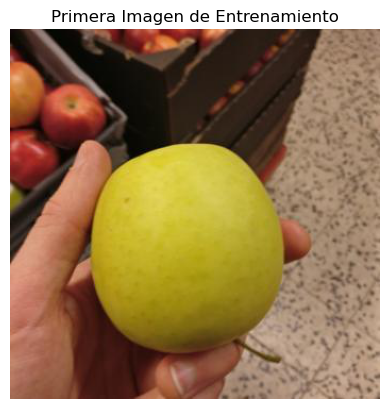

Dimensiones de la matriz de la imagen: (348, 348, 3)
Tamaño total de la matriz de la imagen: 363312
DataFrame de la matriz de la imagen:
   Red  Green  Blue
0   20      8    12
1   20      8    12
2   20      8    10
3   20     10    11
4   21     11    10


In [24]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd

# Mostrar la primera imagen del DataFrame de entrenamiento
first_image_path = train_df.iloc[0]['image_path']
print(f"Ruta de la primera imagen: {first_image_path}")

# Cargar la imagen
image = Image.open(first_image_path)

# Mostrar la imagen
plt.imshow(image)
plt.axis('off')  # Quitar ejes para mejor visualización
plt.title("Primera Imagen de Entrenamiento")
plt.show()

# Convertir la imagen a forma matricial
image_matrix = np.array(image)

# Mostrar las dimensiones de la matriz
print(f"Dimensiones de la matriz de la imagen: {image_matrix.shape}")

# Calcular el tamaño de la matriz (número total de elementos)
print(f"Tamaño total de la matriz de la imagen: {image_matrix.size}")

# Convertir la matriz de la imagen en un DataFrame
image_df = pd.DataFrame(image_matrix.reshape(-1, image_matrix.shape[2]),
                        columns=['Red', 'Green', 'Blue'])

# Mostrar las primeras filas del DataFrame de la imagen
print("DataFrame de la matriz de la imagen:")
print(image_df.head())

## Preprocesamiento y Transformaciones

Conociendo que algunas de las imágenes no tienen las mismas condiciones de tamaño, se va a realizar un preprocesamiento a todas las imagenes de los tres datasets para que no se generen conflictos en el modelo. También se va a realizar una aumentación de datos modificando su rotación, aplicando zoom aleatorios y normalización de los datos

Found 2640 validated image filenames belonging to 81 classes.
Found 296 validated image filenames belonging to 81 classes.
Found 2485 validated image filenames belonging to 81 classes.
Found 2640 validated image filenames belonging to 81 classes.
Generadores creados y datos preprocesados.
Ejemplos de aumento de datos:


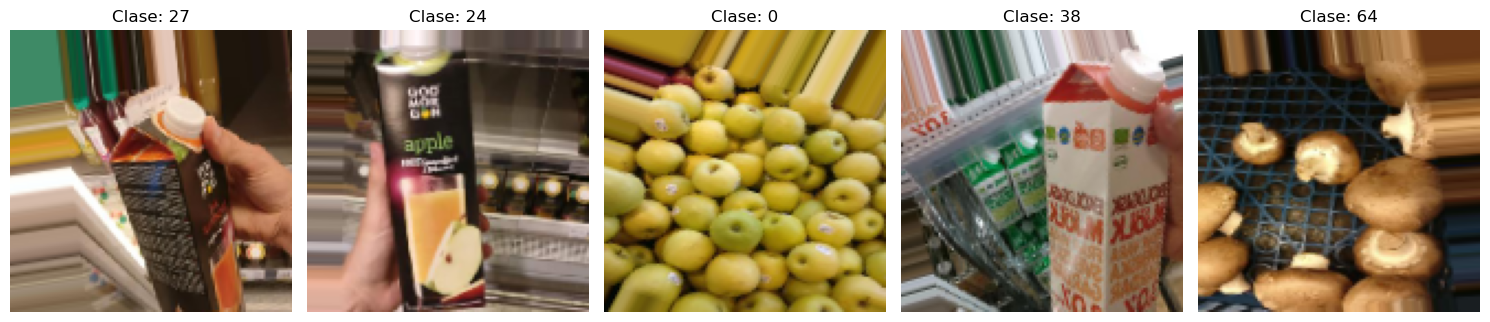

In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Dimensiones de las imágenes para la red convolucional
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32


# Convertir las etiquetas del DataFrame a cadenas
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

# Preprocesamiento inicial: Generar generadores de imágenes desde los DataFrames
def preprocess_data(dataframe):
    datagen = ImageDataGenerator(
        rescale=1.0/255,  # Normalización a [0, 1]
    )
    generator = datagen.flow_from_dataframe(
        dataframe=dataframe,
        x_col='image_path',
        y_col='label',
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    return generator

# Preparar generadores para entrenamiento, validación y prueba
train_generator = preprocess_data(train_df)
val_generator = ImageDataGenerator(
    rescale=1.0/255  # Normalización
).flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    classes=list(train_generator.class_indices.keys())  # Usar clases del entrenamiento
)
test_generator = preprocess_data(test_df)

# Transformaciones de datos: Aumento para entrenamiento
augmented_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,        # Rotaciones aleatorias
    width_shift_range=0.2,    # Desplazamiento horizontal
    height_shift_range=0.2,   # Desplazamiento vertical
    shear_range=0.2,          # Transformaciones en forma
    zoom_range=0.2,           # Zoom aleatorio
    horizontal_flip=True      # Espejado horizontal
)

augmented_train_generator = augmented_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

print("Generadores creados y datos preprocesados.")

# Visualizar ejemplos del aumento de datos

import matplotlib.pyplot as plt

# Función para visualizar ejemplos de aumento de datos
def visualize_augmentation(generator, num_images=5):
    # Obtener un batch de imágenes y etiquetas
    images, labels = next(generator)

    # Crear una figura para visualizar
    plt.figure(figsize=(15, num_images))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(f"Clase: {labels[i].argmax()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualizar ejemplos del aumento de datos
print("Ejemplos de aumento de datos:")
visualize_augmentation(augmented_train_generator)



Después de haber realizado la modificación de los datos en los datasets, vamos a revisar la distribución que se presenta en el dataset de prueba para conocer la cantidad de datos que se presentan

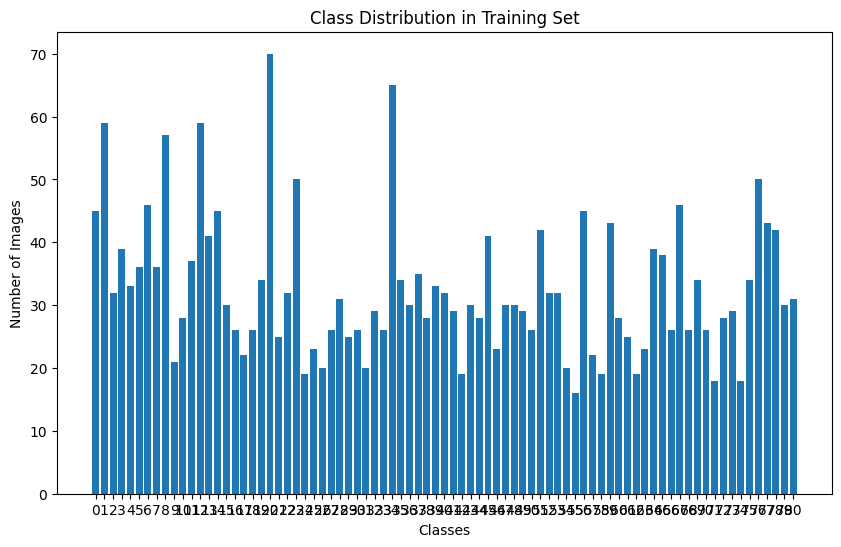

In [ ]:
import matplotlib.pyplot as plt

class_counts = train_generator.classes
unique_classes, counts = np.unique(class_counts, return_counts=True)

plt.figure(figsize=(10, 6))
plt.bar(unique_classes, counts)
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training Set")
plt.xticks(unique_classes)
plt.show()

Con la información de la distribución, se observa que existen algunas clases con pocos datos, por lo que al momento de entrenar el modelo pueden existir fallos detectando estas clases. Cabe aclarar que se esta realizando la ejecución del modelo con todas las clases disponibles de los elementos del dataset, no en el segundo nivel de jerarquía disponible.

## 2. Entrenamiento del modelo

## Definición capas

In [7]:
from tensorflow.keras import layers, models
num_classes = train_generator.class_indices  # Diccionario de clases y sus índices
num_classes = len(num_classes)  # Número total de clases

def create_improved_model(input_shape, num_classes):
    model = models.Sequential([
        # Primera capa convolucional
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Segunda capa convolucional
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Tercera capa convolucional
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Cuarta capa convolucional
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.5),

        # Global Average Pooling en lugar de Flatten
        layers.GlobalAveragePooling2D(),

        # Fully Connected Layer
        layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # Capa de salida
        layers.Dense(num_classes, activation='softmax')
    ])


    return model

# Definir dimensiones de entrada y número de clases
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)  # Altura, Ancho, Canales (RGB)

# Crear el modelo mejorado
model = create_improved_model(input_shape, num_classes)

# Resumen del modelo
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             5

 Total params: 434,193 (1.66 MB)

 Trainable params: 432,977 (1.65 MB)

 Non-trainable params: 1,216 (4.75 KB)

## Entrenamiento

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers, models, regularizers

from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
# Revisar las clases del generador
print(f"Clases detectadas: {train_generator.class_indices}")
num_classes = len(train_generator.class_indices)  # Ajustar número de clases

# Redefinir el modelo con el número correcto de clases
model = create_improved_model(input_shape, num_classes)

model.summary()

# Planificador de tasa de aprendizaje
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = Adam(learning_rate=lr_schedule)

# Compilar el modelo
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Configurar callbacks
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    mode='max',
    verbose=1
)

# Entrenar el modelo
history = model.fit(
    augmented_train_generator,  # Generador con aumento de datos
    validation_data=val_generator,
    epochs=30,  # Incrementar las épocas
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

Clases detectadas: {'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '16': 8, '17': 9, '18': 10, '19': 11, '2': 12, '20': 13, '21': 14, '22': 15, '23': 16, '24': 17, '25': 18, '26': 19, '27': 20, '28': 21, '29': 22, '3': 23, '30': 24, '31': 25, '32': 26, '33': 27, '34': 28, '35': 29, '36': 30, '37': 31, '38': 32, '39': 33, '4': 34, '40': 35, '41': 36, '42': 37, '43': 38, '44': 39, '45': 40, '46': 41, '47': 42, '48': 43, '49': 44, '5': 45, '50': 46, '51': 47, '52': 48, '53': 49, '54': 50, '55': 51, '56': 52, '57': 53, '58': 54, '59': 55, '6': 56, '60': 57, '61': 58, '62': 59, '63': 60, '64': 61, '65': 62, '66': 63, '67': 64, '68': 65, '69': 66, '7': 67, '70': 68, '71': 69, '72': 70, '73': 71, '74': 72, '75': 73, '76': 74, '77': 75, '78': 76, '79': 77, '8': 78, '80': 79, '9': 80}


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 128)                 │             5

 Total params: 434,193 (1.66 MB)

 Trainable params: 432,977 (1.65 MB)

 Non-trainable params: 1,216 (4.75 KB)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.0540 - loss: 6.1526
Epoch 1: val_accuracy improved from -inf to 0.01689, saving model to best_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 663s 7s/step - accuracy: 0.0543 - loss: 6.1471 - val_accuracy: 0.0169 - val_loss: 6.0642
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1214 - loss: 4.8452
Epoch 2: val_accuracy did not improve from 0.01689
83/83 ━━━━━━━━━━━━━━━━━━━━ 233s 3s/step - accuracy: 0.1217 - loss: 4.8429 - val_accuracy: 0.0135 - val_loss: 6.4830
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1869 - loss: 4.1695
Epoch 3: val_accuracy did not improve from 0.01689
83/83 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.1871 - loss: 4.1682 - val_accuracy: 0.0135 - val_loss: 7.4025
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2649 - loss: 3.6295
Epoch 4: val_accuracy improved from 0.01689 to 0.02365, saving model to best_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.

# 3. Resultados del modelo

## Prueba de modelo

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Loss en conjunto de prueba: {test_loss}")
print(f"Accuracy en conjunto de prueba: {test_accuracy}")

78/78 ━━━━━━━━━━━━━━━━━━━━ 48s 619ms/step - accuracy: 0.4136 - loss: 2.5065
Loss en conjunto de prueba: 2.4912269115448
Accuracy en conjunto de prueba: 0.40885311365127563


Tras entrenar el modelo en el dataset proporcionado, se obtuvieron los siguientes resultados:

Conjunto de Entrenamiento:

* Accuracy: 0.41
* Loss: 2.50

Conjunto de Prueba:

* Accuracy: 0.408
* Loss: 2.49

Estos valores muestran una consistencia entre los conjuntos de entrenamiento y prueba, lo que indica que el modelo no está sobreajustado ni subajustado de forma significativa. Sin embargo, la precisión general sugiere que el modelo tiene dificultades para diferenciar correctamente las clases, y el alto valor de **loss** apunta a que las predicciones están lejos de las etiquetas reales en muchos casos.

Para obtener este resultado ayudo significativamente el preprocesamiento del dataset, la normalización del dataset y la modificación del formato "básico" del modelo de red neuronal convolucional, donde se utilizar 4 capas internas con una normalización a sus resultados de salida y el uso de una capa **global average pooling** para acelerar y estabilizar el proceso de aprendizaje. También en la capa de salida se aplicó una regularización **L2** para evitar el sobreajuste y problemas que se puedan presentar en zonas muertas.

Como oportunidades de mejora, se pueden agregar más datos al dataset de entrenamiento, aplicando más modificaciones a las imagenes originales para que la cantidad de datos sea mayor, y en clases que tengan poca información su entrenamiento pueda mejorar. Como segunda oportunidad se puede realizar la búsqueda de hiperpárametros que optimicen el entrenamiento y mejoren el resultado de este. Finalmente se puede realizar la implementación de modelos preentrenados para esta clase de problemas, que pueda mejorar los resultados al generar mejores características.

# 4. Generación de valor

Para calcular la generación de valor tendremos en cuenta la siguiente ecucación:

$$ â = a - (1 - I) * e $$

Donde

* â = Resultado de ahorros por predicción
* a = Ahorro esperado
* I = Precisión del modelo calculada
* e = Coste de arregalar un error manualmente

A partir de esta información vamos a definir lo siguiente:

* a = 2 segundos
* e = 5 segundos

Donde:

$$ â = 2- (1-0.408) * 5$$
$$ â = -0.96 $$

Al tener como resultado de ganancia un valor negativo, vamos a revisar como afecta en terminos monetarios esto.

Para el calcula de la generación de valor vamos a tener varios supuestos al iniciar:

1. Costo total del modelo: 10000 €
2. Operación mensual y mantenimiento del modelo: 2000 €/mes
3. Beneficios mensuales: 7000 €

Con estos datos vamos a calcular lo siguiente

1. Beneficio actual

$$ Beneficio actual = (porcentaje del modelo * beneficios mensuales) $$
$$ Beneficio actual = 2856 €/mes $$

2. ROI

$$ ROI = (Beneficio actual - costos mensuales) / (costos totales de inversión) * 100 $$
$$ ROI = 7.13% $$

Al tener un ROI bajo, se espera que se puedan realizar actualizaciones al modelo que puedan generar un mayor valor a la empresa al momento de implementarlo, esto se consigue al momento en que se logre entregar un modelo con una precisión más alta, al menos de un 0.7%, así como también reducir los costos de desarrollo del modelo y de mantenimiento de este.

# 5. Insgihts finales

* Al tener un ROI positivo pero pequeño, se está empezando a generar valor y recuperar los costos de inversión realizados, pero es necesario que se mejore más el modelo, para que el retorno sea más significativo a corto plazo.
* Aunque los errores son significativos, el modelo ya contribuye a reducir costos relacionados con la clasificación manual, optimización del inventario, o mejoras en la calidad de las recomendaciones.
* El retorno actual sugiere que el modelo está en una etapa temprana. Si se mejora la precisión o se ajustan las operaciones, el ROI podría multiplicarse.
* Implementarse el modelo en este momento puede presentar problemas si se llegan a generar una subida de precios en los productos, lo que disminuría el valor actual del retorno de inversión, pudiendo llegar a ser hasta un valor negativo.